In [95]:
import pandas as pd
import numpy as np
import html

In [96]:
users_df = pd.read_csv("data/Users.csv")
postHistory_df = pd.read_csv("data/PostHistory.csv", low_memory=False)

# clean users_df
users_df.drop(["Location", "Views", "WebsiteUrl", "EmailHash", "AboutMe", "ProfileImageUrl"], inplace=True, axis=1)
postHistory_df.drop(["ContentLicense", "CommunityOwnedDate", "ClosedDate", "LastActivityDate", "LastEditDate", "LastEditorDisplayName", "LastEditorUserId", "CreationDate", "DeletionDate"], inplace=True, axis=1)

post_enums = {
    "Question": 1,
    "Answer": 2
}

def unescape_if_not_nan(val): return val if pd.isna(val) else html.unescape(val)

postHistory_df.drop(postHistory_df[postHistory_df["OwnerUserId"] == "OwnerUserId"].index, inplace=True)
postHistory_df = postHistory_df.replace("NaN", np.nan)
postHistory_df["Title"] = postHistory_df["Title"].apply(unescape_if_not_nan)
postHistory_df["Body"] = postHistory_df["Body"].apply(unescape_if_not_nan)
postHistory_df["Body"] = postHistory_df["Body"].replace(r"<[^>]+>", ' ', regex=True)

for col in ["Score", "Id", "OwnerUserId", "PostTypeId"]:
    postHistory_df[col] = postHistory_df[col].astype(int)

# num posts
numPosts_df = postHistory_df.groupby("OwnerUserId").size()

# add in numPosts to each user
for id, numPosts in numPosts_df.items():

    # grouping to find more information about a user's activity
    user_posts = postHistory_df[postHistory_df["OwnerUserId"] == id]
    type_of_posts = user_posts.groupby("PostTypeId")
    num_posts = type_of_posts["Id"].count()
    avg_posts = type_of_posts["Score"].mean()

    # count number or questions and answers that a user has posted
    user_questions = num_posts.loc[post_enums["Question"]] if post_enums["Question"] in num_posts.index else 0
    user_answers = num_posts.loc[post_enums["Answer"]] if post_enums["Answer"] in num_posts.index else 0

    # calculate score for all user questions
    # NaN is used if user hasn't posted a question or answer
    avg_question_score = avg_posts.loc[post_enums["Question"]] if post_enums["Question"] in avg_posts.index else np.nan
    avg_answer_score = avg_posts.loc[post_enums["Answer"]] if post_enums["Answer"] in avg_posts.index else np.nan

    # add information about current user to users_df
    users_df.loc[users_df["Id"] == id, "NumPosts"] = numPosts
    users_df.loc[users_df["Id"] == id, "NumQuestions"] = user_questions
    users_df.loc[users_df["Id"] == id, "NumAnswers"] = user_answers
    users_df.loc[users_df["Id"] == id, "AvgQuestionScore"] = avg_question_score
    users_df.loc[users_df["Id"] == id, "AvgAnswerScore"] = avg_answer_score


In [97]:
postHistory_df.head(10)

,Id,PostTypeId,AcceptedAnswerId,ParentId,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,1180,1,1232,NaN,25,5863,I am looking to allow users to control of sub...,281,NaN,How to make subdomain user accounts in a webapp,<web-applications><dns><subdomain><account>,4,0,0
1,15734,1,775195,NaN,15,14514,I know that there is no official API for Goog...,1890,Detlef D Doerscheln,Google Analytics Access with C#,<c#><google-analytics><google-analytics-api>,9,0,0
2,16757,2,NaN,8472,2,NaN,My solution was to put the form on a separate...,744,dsims,NaN,NaN,NaN,0,NaN
3,16926,1,330236,NaN,20,2361,"My HTML is all marked up, ready to make it ra...",744,dsims,Tool for generating CSS skeleton?,<css><markup>,9,0,0
4,20321,1,NaN,NaN,9,1781,I am developing a website that will manage da...,744,dsims,One database or many?,<performance><database-design><multi-tenant><m...,11,0,0
5,22699,2,NaN,7252,20,NaN,"For myself, I have started insisting that eve...",2509,NaN,NaN,NaN,NaN,2,NaN
6,22718,2,NaN,1669,5,NaN,"I liked the Crenshaw tutorial too, because ...",2509,dmckee,NaN,NaN,NaN,0,NaN
7,23017,2,NaN,1496,1,NaN,I get all my unixish/GNU support using Fink ...,2509,dmckee,NaN,NaN,NaN,0,NaN
8,23052,2,NaN,23031,0,NaN,I've only recently added unit testing to my r...,2509,dmckee,NaN,NaN,NaN,0,NaN
9,24259,2,NaN,3260,6,NaN,This problem has been studied in some detail....,2509,dmckee,NaN,NaN,NaN,0,NaN


In [98]:
reps = 0
for user in users_df.iterrows():
    reps += user[1]['Reputation']

avg_sample_rep = reps/users_df.shape[0]    

print(f"Average Sample Reputation: {round(avg_sample_rep, 2)}")

Average Sample Reputation: 319.85


In [99]:
len(users_df.index)

users_df[users_df["Reputation"] == 234218]

,Id,Reputation,CreationDate,DisplayName,LastAccessDate,UpVotes,DownVotes,AccountId,NumPosts,NumQuestions,NumAnswers,AvgQuestionScore,AvgAnswerScore
448,12870,234218,1221580948227,Oli,1682594779717,997,158,7412,827.0,212.0,615.0,80.990566,9.611382


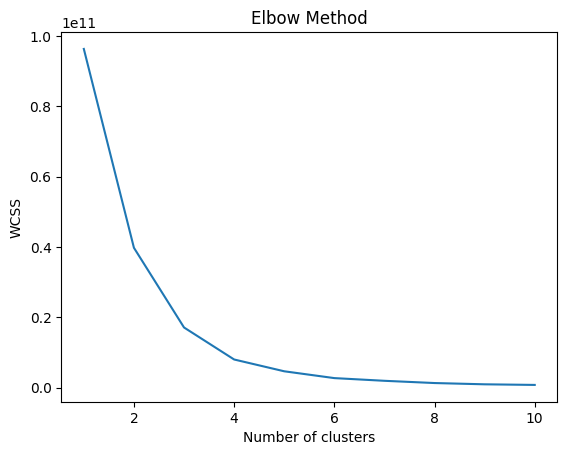

In [100]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

X = users_df[["Reputation", "NumPosts"]].values

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


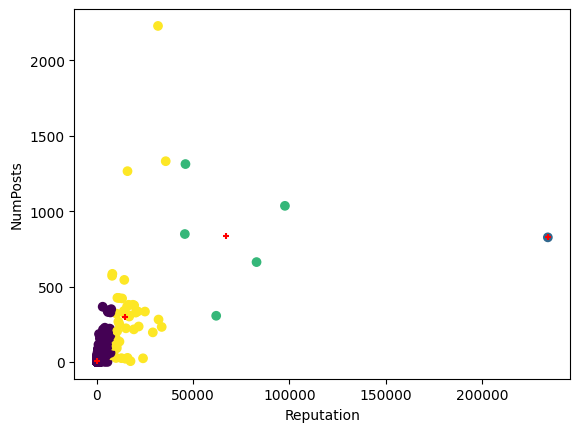

,Reputation,NumPosts,NumQuestions,NumAnswers,AvgQuestionScore,AvgAnswerScore,AvgUpVotesGiven,AvgDownVotesGiven
0,169.284756,6.772173,3.413936,3.351639,12.539251,21.386136,23.072811,2.686389
3,14759.740741,296.203704,59.944444,235.962963,217.588626,116.208506,1023.592593,95.222222
2,66822.600000,833.600000,37.400000,791.400000,103.685113,100.813167,3108.800000,990.000000
1,234218.000000,827.000000,212.000000,615.000000,809.905660,96.113821,997.000000,158.000000


In [101]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# k-means with reputation and numposts
data = users_df[['Reputation', 'NumPosts']].values

kmeans = KMeans(n_clusters=4)
kmeans.fit(data)

labels = kmeans.labels_
users_df['Cluster'] = labels

labels = kmeans.labels_
centers = kmeans.cluster_centers_

# scatter plot dis bih
plt.scatter(data[:, 0], data[:, 1], c=labels)

# plot center of each group
plt.scatter(centers[:, 0], centers[:, 1], marker='+', s=25, color='red')

plt.xlabel('Reputation')
plt.ylabel('NumPosts')
plt.show()


users_df.head(10)

analysis_df = pd.DataFrame(columns=["Reputation", "NumPosts"])

for label in set(labels):
    cluster = users_df[users_df['Cluster'] == label]
    new_row = pd.DataFrame([
        {
            'Reputation': cluster["Reputation"].mean(),
            'NumPosts': cluster["NumPosts"].mean(),
            'NumQuestions': cluster["NumQuestions"].mean(),
            'NumAnswers': cluster["NumAnswers"].mean(),
            'AvgQuestionScore': cluster["AvgQuestionScore"].mean() * 10, # multiply by 10 because that's how much rep 1 score point is worth (https://stackoverflow.help/en/articles/4396982-reputation)
            'AvgAnswerScore': cluster["AvgAnswerScore"].mean() * 10,
            'AvgUpVotesGiven': cluster["UpVotes"].mean(),
            'AvgDownVotesGiven': cluster["DownVotes"].mean()
        }
    ])

    analysis_df = pd.concat([analysis_df, new_row], ignore_index=True)

analysis_df.sort_values("Reputation", ascending=True).head(20)


In [102]:
# What are some of the best questions-- questions that have generated high scores
# for our analysis, we are uing the top 100
questions_df = postHistory_df[postHistory_df["PostTypeId"] == post_enums["Question"]]
questions_df = questions_df.sort_values("Score", ascending=False).iloc[:100]


752       There are many "standards" for the  JSON  con...
741       How do I convert the following string to a   ...
105       The "N+1 selects problem" is generally stated...
76        I have a ~23000 line SQL dump containing seve...
45746     I've run out of space on a virtual machine di...
                               ...                        
39356     I have a big file. It includes approximately ...
67831     I am trying to make a python package which I ...
43158     I have this problem when I simulate my app, i...
40551     I am trying to push my app to heroku and I ge...
16768     I'm working on an app where I need to display...
Name: Body, Length: 100, dtype: object

In [112]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# What makes the question 'good'-- look for keywords, so on
# regex in token ensures grabbing words-- by default, will ignore apostrophes
count_vectorizer = CountVectorizer(stop_words="english", max_features=50, token_pattern=r"(?u)\b\w[\w']+\b")

# keywords in title
title_word_counts = count_vectorizer.fit_transform(questions_df["Title"])
title_keywords = count_vectorizer.get_feature_names_out()

# keywords in body
body_word_counts = count_vectorizer.fit_transform(questions_df["Body"])
body_keywords = count_vectorizer.get_feature_names_out()

tag_counter = Counter()
for tags in questions_df["Tags"]:
    tag_list = tags.split('|')  # Assuming tags are separated by '|'
    tag_counter.update(tag_list)

common_tags = tag_counter.most_common(20)

# 5. Investigate engagement metrics
average_viewcount = np.mean(questions_df["ViewCount"])
average_answercount = np.mean(questions_df["AnswerCount"])
average_commentcount = np.mean(questions_df["CommentCount"])
average_favoritecount = np.mean(questions_df["FavoriteCount"])

print("Title keywords:", title_keywords)
print("Body keywords:", body_keywords)
print("Common tags:", common_tags)
print("Average view count:", average_viewcount)
print("Average answer count:", average_answercount)
print("Average comment count:", average_commentcount)
print("Average favorite count:", average_favoritecount)

['android' 'check' 'chrome' 'classes' 'clr' 'code' 'const' 'convert'
 'core' 'data' 'database' 'difference' 'django' 'does' "doesn't" 'file'
 'float' 'google' 'install' 'int' 'integer' 'java' 'javascript' 'json'
 'language' 'length' 'line' 'list' 'multiple' 'mysql' 'net' 'object'
 'package' 'parameters' 'pip' 'possible' 'python' 'remove' 'server' 'sql'
 'store' 'string' 'swift' 'text' 'type' 'using' 'vs' 'way' 'web' 'window']
['app' 'build' 'case' 'class' 'code' 'com' 'command' 'connection' 'data'
 'does' 'echweb' 'error' 'example' 'file' 'float' 'following' 'function'
 'git' "i'm" "i've" 'int' 'just' 'know' 'language' 'like' 'line' 'need'
 'new' 'object' 'problem' 'public' 'python' 'rand' 'result' 'return' 'run'
 'string' 'text' 'time' 'transaction' 'type' 'url' 'use' 'using' 'value'
 'var' 'version' 'want' 'way' 'web']
